### Modelo RFM

Siglas: Recency, Frequency, Monetary.

Es un modelo de segmentación de clientes.

**Recencia:** tiempo (puede ser en días) que ha pasado desde la última transacción que realizó un cliente. La transacción puede ser: última compra, suscripción o registro, carrito abandonado, etc.

**Frecuencia:** número de transacciones realizadas en un período de tiempo.

**Valor Monetario:** valor total (en unidades monetarias) de las transacciones realizadas.

Este modelo es una aplicación muy sencilla, que tiene explícitas las tablas de R,F,M ni la sponderaciones. Adicional no tiene aplicadas reglas de negocio de la empresa en la que se aplica.

In [1]:
import pandas as pd
import seaborn as sns
from datetime import timedelta
import matplotlib.pyplot as plt
import squarify
import warnings
warnings.filterwarnings("ignore")

# Lectura de datos
data = pd.read_excel('BaseVentasDoc.xlsx', engine = 'openpyxl')
data.head()

,Unnamed: 0,f461_id_cia,v470_rowid_docto,periodo,fecha,tipo_docto,nro_docto,fecha_pedido,pedido_docto,motivo,...,precio_unit,valor_bruto_local,valor_dscto_local,valor_subtotal_local,valor_neto_local,costo_prom_uni,costo_promedio,margen_promedio,id_lista_precios,estado
0,0,1,5060163,202101,20-01-2021,FED,FED-00007669,20-11-2020,PED-01308694,01-Ventas,...,93486.00,93486.00,0.0,93486.00,111248.34,52214.499,52012.07,44.36,007 - SODIMAC-CAFAM-FALABELLA,Aprobada
1,1,1,5060182,202101,20-01-2021,FED,FED-00007668,20-11-2020,PED-01308580,01-Ventas,...,59212.59,59212.59,0.0,59212.59,70462.98,33118.250,32989.34,44.28,007 - SODIMAC-CAFAM-FALABELLA,Aprobada
2,2,1,5061633,202101,15-01-2021,FED,FED-00007649,23-11-2020,PED-01309092,01-Ventas,...,347252.00,347252.00,0.0,347252.00,413229.88,193038.650,192301.67,44.62,007 - SODIMAC-CAFAM-FALABELLA,Aprobada
3,3,1,5069150,202101,15-01-2021,FED,FED-00007650,26-11-2020,PED-01310624,01-Ventas,...,59212.59,59212.59,0.0,59212.59,70462.98,33118.250,32989.34,44.28,999 - LISTA DE PRECIOS LIBRE,Aprobada
4,4,1,5071201,202101,20-01-2021,FED,FED-00007670,29-11-2020,PED-01312016,01-Ventas,...,2038186.00,2038186.00,0.0,2038186.00,2425441.34,1481440.615,1527679.47,25.04,007 - SODIMAC-CAFAM-FALABELLA,Aprobada


In [2]:
# La fecha se debe llevar a formato datetime
data['fecha'] = pd.to_datetime(data['fecha'])

In [3]:
# Dimensiones del dataset
print('El dataset tiene {:,} filas; {:,} columnas.'
      .format(data.shape[0], data.shape[1]))
print('Hay {:,} transacciones que no tienen ID del cliente.'
      .format(data[data.f461_rowid_tercero_fact.isnull()].shape[0]))
print('Rango de fechas: las transacciones van desde el {} hasta el {}.'.format(data['fecha'].min(),
                                    data['fecha'].max()))

El dataset tiene 592,721 filas; 29 columnas.
Hay 0 transacciones que no tienen ID del cliente.
Rango de fechas: las transacciones van desde el 2021-01-02 00:00:00 hasta el 2021-12-06 00:00:00.


In [4]:
# --Se requiere agrupar el dataset por ID del Cliente--
# Se crea columna TotalSum (Esto para el Valor Monetario)
data['TotalSum'] = data['valor_subtotal_local']

# Creación de fecha de referencia
snapshot_date = data['fecha'].max() + timedelta(days=1)
print(snapshot_date)

# Agrupación por ID del Cliente
data_process = data.groupby(['f461_rowid_tercero_fact']).agg({
        'fecha': lambda x: (snapshot_date - x.max()).days, # Acá se calcula la recencia en días
        'f461_rowid_tercero_fact': 'count', # Conteo de facturas por cliente. Esto se asume frecuencia, pero hay otras alternativas.
        'TotalSum': 'sum'}) # Valor Monetario 

# Se renombran las columnas 
data_process.rename(columns={'fecha': 'Recencia',
                         'f461_rowid_tercero_fact': 'Frecuencia',
                         'TotalSum': 'Valor Monetario'}, inplace=True)

2021-12-07 00:00:00


In [5]:
# Head del nuevo dataset
print(data_process.head())
# Shape del nuevo dataset
print('Hay {:,} clientes y sus datos {:,} columnas de RFM.'.format(data_process.shape[0], data_process.shape[1]))

                         Recencia  Frecuencia  Valor Monetario
f461_rowid_tercero_fact                                       
7                              31          13       1076336.18
20                             32           4        261108.72
37                            159         141      12893462.46
38                            123         111      10458202.24
75                            126          13       2583633.00
Hay 7,162 clientes y sus datos 3 columnas de RFM.


Siempre se recomienda que los conteos se hagan por elementos numéricos (ID del cliente).

Se examina la distribución de Recencia, Frecuencia y Valor Monetario.

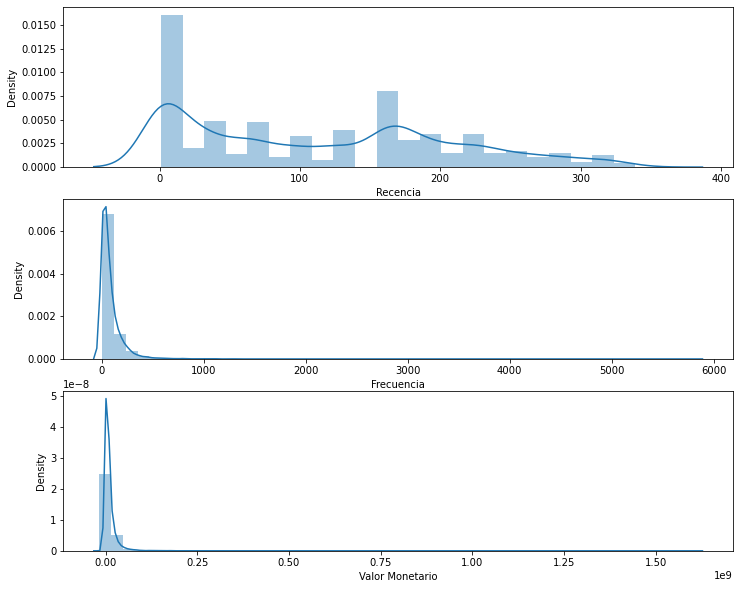

In [6]:
plt.figure(figsize=(12,10))
plt.subplot(3, 1, 1); sns.distplot(data_process['Recencia'])
plt.subplot(3, 1, 2); sns.distplot(data_process['Frecuencia'])
plt.subplot(3, 1, 3); sns.distplot(data_process['Valor Monetario'])
plt.show()

Ahora empieza la segmentación. Se usará el método .qcut() para asignar el percentil relativo a la RFM característica.

La puntuación posible por grupo (R o F) es 1,2,3 o 4. Esta es una metodología bastante simple.

In [7]:
# --Calcular grupos para R and F --. 

# Creación de labels para Recencia y Frecuencia
r_labels = range(4, 0, -1); f_labels = range(1, 5)
# Se asignan los labels a los grupos de Recencia
r_groups = pd.qcut(data_process['Recencia'], q=4, labels=r_labels)
# Se asignan los labels a los grupos de Frecuencia
f_groups = pd.qcut(data_process['Frecuencia'], q=4, labels=f_labels)
# Creación de nuevas columnas R y F 
data_process = data_process.assign(R = r_groups.values, F = f_groups.values)
data_process.head()

,Recencia,Frecuencia,Valor Monetario,R,F
f461_rowid_tercero_fact,,,,,
7,31,13,1076336.18,4,1
20,32,4,261108.72,3,1
37,159,141,12893462.46,2,4
38,123,111,10458202.24,2,4
75,126,13,2583633.00,2,1


La puntuación posible por grupo (M) también es 1,2,3 o 4.

In [8]:
# Creación de labels para Valor Monetario
m_labels = range(1, 5)
# Se asignan los labels a los grupos
m_groups = pd.qcut(data_process['Valor Monetario'], q=4, labels=m_labels)
# Creación de la columna M
data_process = data_process.assign(M = m_groups.values)

In [9]:
# Concatenar valores RFM para luego crear segmentos con todas las combinaciones de valores RFM
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
data_process['RFM_Segment_Concat'] = data_process.apply(join_rfm, axis=1)
rfm = data_process
rfm.head()

,Recencia,Frecuencia,Valor Monetario,R,F,M,RFM_Segment_Concat
f461_rowid_tercero_fact,,,,,,,
7,31,13,1076336.18,4,1,1,4.01.01.0
20,32,4,261108.72,3,1,1,3.01.01.0
37,159,141,12893462.46,2,4,4,2.04.04.0
38,123,111,10458202.24,2,4,3,2.04.03.0
75,126,13,2583633.00,2,1,2,2.01.02.0


In [10]:
# Conteo del número de segmentos
rfm_count_unique = rfm.groupby('RFM_Segment_Concat')['RFM_Segment_Concat'].nunique()
print('Hay {:,} distintas combinaciones de valores RFM. Estas pueden ser segmentos de clientes.'.format(rfm_count_unique.sum()))

Hay 63 distintas combinaciones de valores RFM. Estas pueden ser segmentos de clientes.


Las anteriores segmentoa ya pueden ser una primera clasificación usando RFM. Sin embargo, es bastante realizar sumas y/o ponderaciones con los valores de las columnas R, F, y M  para llegar a un valor general (RFM Score) con el que luego se puedan realizar agrupaciones (segmentaciones).

### Sumando el Score
Uno de los métodos más simples es llevar los labels de R,F y M, por suma simple, a un solo número (RFM Score) y definir RFM levels para cada rango de score.

In [11]:
# Cálculo del RFM_Score como suma
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
print(rfm['RFM_Score'].head())

f461_rowid_tercero_fact
7      6
20     5
37    10
38     9
75     5
Name: RFM_Score, dtype: int64


En función al resultado de la suma (RFM_Score) es posible crear escalas y hacer hipótesis sobre lo que puede representar cada rango de RFM_score.

A continuación se exploran dos segmentaciones distintas: una de 7 grupos (segmentos) y otra de 5 grupos (segmentos).

In [12]:
# Alternativa 1
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return 'A - No se pueden perder'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'B - Campeones'
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return 'C - Leal'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
        return 'D - Potencial'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return 'E - Prometedor'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
        return 'F - Necesita atención'
    else:
        return 'G - Requiere activación'
# Se crea una nueva variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)
rfm.head()

,Recencia,Frecuencia,Valor Monetario,R,F,M,RFM_Segment_Concat,RFM_Score,RFM_Level
f461_rowid_tercero_fact,,,,,,,,,
7,31,13,1076336.18,4,1,1,4.01.01.0,6,D - Potencial
20,32,4,261108.72,3,1,1,3.01.01.0,5,E - Prometedor
37,159,141,12893462.46,2,4,4,2.04.04.0,10,A - No se pueden perder
38,123,111,10458202.24,2,4,3,2.04.03.0,9,A - No se pueden perder
75,126,13,2583633.00,2,1,2,2.01.02.0,5,E - Prometedor


In [13]:
# Finalmente se agrupan los clientes por su RFM level

# Se calculan los valores promedio para cada segmento, y la cantidad de clientes en cada segmento. 
rfm_level_agg = rfm.groupby('RFM_Level').agg({
    'Recencia': 'mean',
    'Frecuencia': 'mean',
    'Valor Monetario': ['mean', 'count']
}).round(1)

print(rfm_level_agg)

                        Recencia Frecuencia Valor Monetario      
                            mean       mean            mean count
RFM_Level                                                        
A - No se pueden perder     44.0      163.8      21110666.6  2839
B - Campeones               97.2       60.7       6891579.3   771
C - Leal                   116.8       43.5       4417372.4   749
D - Potencial              133.3       29.5       3468291.4   784
E - Prometedor             164.8       20.4       1981804.1   695
F - Necesita atención      198.0       12.1       1094050.9   569
G - Requiere activación    256.9        5.5        433939.5   755


Interpretación:

In [14]:
# Visualización de los datos
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecenciaMean','FrequenciaMean','Valor MonetarioMean', 'Count']

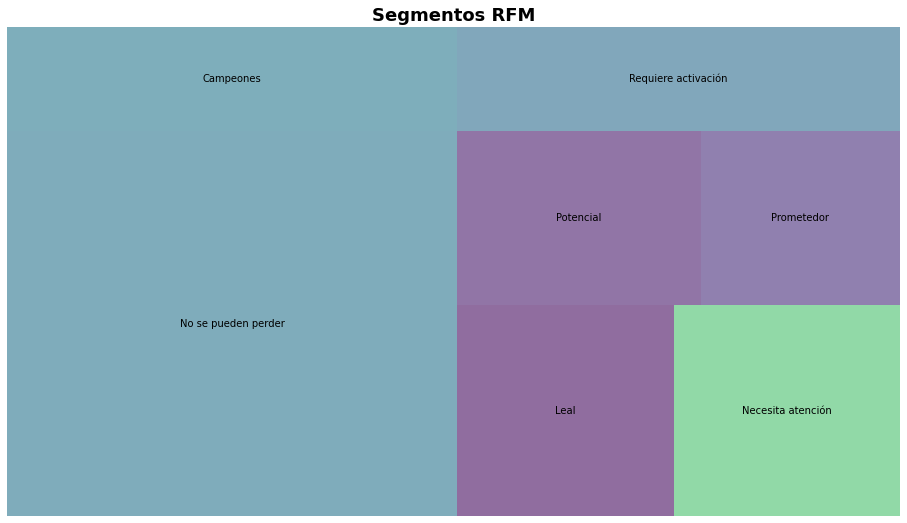

In [15]:
# Se crea la figura y se asigna tamaño
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['No se pueden perder',
                     'Campeones',
                     'Leal',
                     'Necesita atención',
                     'Potencial', 
                     'Prometedor', 
                     'Requiere activación'], alpha=.6 )
plt.title("Segmentos RFM",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

In [16]:
# Alternativa 2
def rfm_level2(df):
    if df['RFM_Score'] >= 11:
        return 'A - VIP'
    elif ((df['RFM_Score'] >= 9.6) and (df['RFM_Score'] < 11)):
        return 'B - Excelentes'
    elif ((df['RFM_Score'] >= 8.4) and (df['RFM_Score'] < 9.6)):
        return 'C - Buenos'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 8.4)):
        return 'D - Regulares'
    else:
        return 'E - Poco aporte'
# Se crea una nueva variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_level2, axis=1)
rfm.head()

,Recencia,Frecuencia,Valor Monetario,R,F,M,RFM_Segment_Concat,RFM_Score,RFM_Level
f461_rowid_tercero_fact,,,,,,,,,
7,31,13,1076336.18,4,1,1,4.01.01.0,6,D - Regulares
20,32,4,261108.72,3,1,1,3.01.01.0,5,E - Poco aporte
37,159,141,12893462.46,2,4,4,2.04.04.0,10,B - Excelentes
38,123,111,10458202.24,2,4,3,2.04.03.0,9,C - Buenos
75,126,13,2583633.00,2,1,2,2.01.02.0,5,E - Poco aporte


In [17]:
# Finalmente se agrupan los clientes por su RFM level

# Se calculan los valores promedio para cada segmento, y la cantidad de clientes en cada segmento. 
rfm_level_agg = rfm.groupby('RFM_Level').agg({
    'Recencia': 'mean',
    'Frecuencia': 'mean',
    'Valor Monetario': ['mean', 'count']
}).round(1)

print(rfm_level_agg)

                Recencia Frecuencia Valor Monetario      
                    mean       mean            mean count
RFM_Level                                                
A - VIP             16.9      234.2      29834283.7  1356
B - Excelentes      60.9      115.7      14699900.3   736
C - Buenos          76.5       83.3      11591388.5   747
D - Regulares      115.8       44.5       4922378.5  2304
E - Poco aporte    208.6       12.5       1152795.0  2019


In [18]:
# Visualización de los datos
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecenciaMean','FrequenciaMean','Valor MonetarioMean', 'Count']

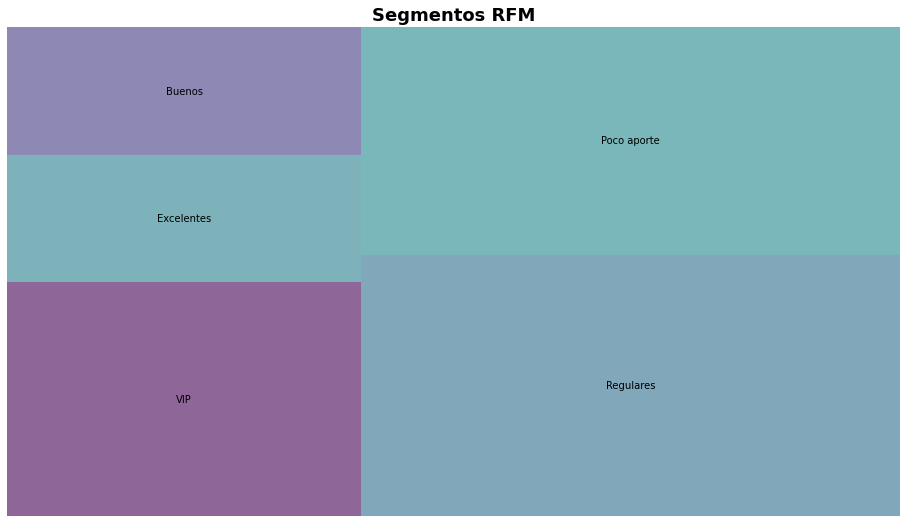

In [19]:
# Se crea la figura y se asigna tamaño
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['VIP',
                     'Excelentes',
                     'Buenos',
                     'Regulares', 
                     'Poco aporte'], alpha=.6 )
plt.title("Segmentos RFM",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

Notar que en el ejemplo anterior se asume la misma importancia a la Recencia, la Frecuencia y el Valor Monetario. Pero esto no siempre es así. En muchos casos es posible encontrar una matriz de ponderación para dar pesos distintas a las variables en la suma final.